In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import cv2

# a)

In [2]:
train_data = pd.read_csv('./Data/HW2_data/Q3_train.csv')
test_data = pd.read_csv('./Data/HW2_data/Q3_test.csv')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
train_data = np.array(train_data)
test_data = np.array(test_data)

X_train, y_train = train_data[:, 1:].astype(float), train_data[:, 0]
X_test, y_test = test_data[:, 1:].astype(float), test_data[:, 0]

In [4]:
mu, sigma = X_train.mean(), X_train.std()
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, sigma)
])

train_images = [X_train[row].reshape((28, 28)) for row in range(X_train.shape[0])]
train_images_normalized = [transform_norm(img) for img in train_images]
test_images = [X_test[row].reshape((28, 28)) for row in range(X_test.shape[0])]
test_images_normalized = [transform_norm(img) for img in test_images]

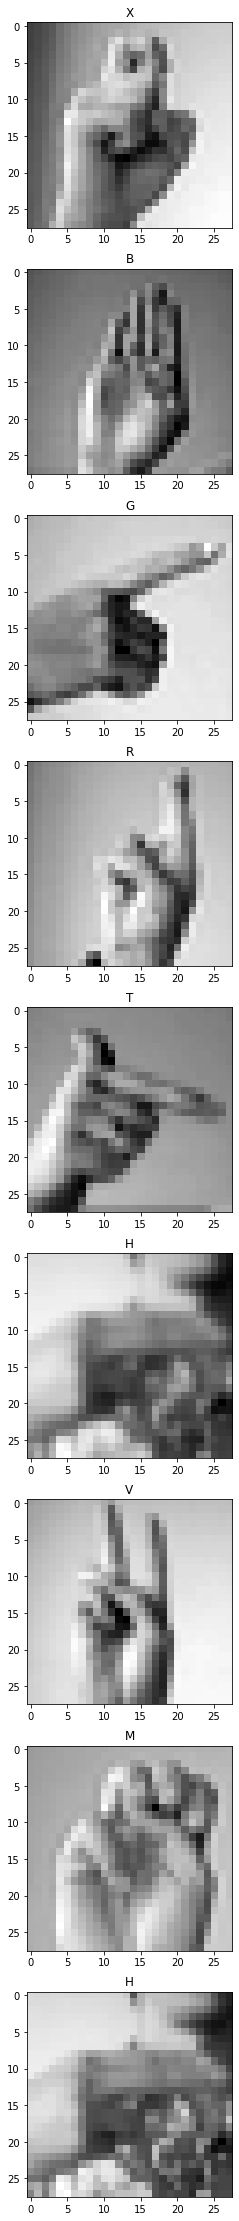

In [163]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(10, 40))
idx = np.random.choice(np.arange(len(train_images)), 9, replace=False)
for i in range(len(idx)):
    ax[i].imshow(train_images_normalized[idx[i]].numpy()[0], cmap='gray')
    ax[i].set_title(chr(y_train[idx[i]]+65))


# b)

In [6]:
training_dataset = TensorDataset(torch.concat(train_images_normalized, dim=0), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.concat(test_images_normalized, dim=0), torch.LongTensor(y_test))

n_train_samples = int(0.8 * len(training_dataset))
n_validation_samples = len(training_dataset) - n_train_samples
training_dataset, validation_dataset = random_split(training_dataset, [n_train_samples, n_validation_samples])

In [7]:
class MyNet(nn.Module):
    def __init__(self, input_size, criterion=nn.CrossEntropyLoss(), optimizer="ADAM", dropout=False, lr=1e-3):
        super(MyNet, self).__init__()
        self.criterion = criterion
        self.input_size = input_size
        if not dropout:
            self.model = nn.Sequential(*[
                nn.Linear(input_size, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 25),
            ])

            torch.nn.init.xavier_normal_(self.model[0].weight)
            torch.nn.init.xavier_normal_(self.model[2].weight)
            torch.nn.init.xavier_normal_(self.model[4].weight)  
            torch.nn.init.xavier_normal_(self.model[6].weight)      
            torch.nn.init.xavier_normal_(self.model[8].weight)
            torch.nn.init.xavier_normal_(self.model[10].weight)
            torch.nn.init.xavier_normal_(self.model[12].weight)

        else:
            self.model = nn.Sequential(*[
                nn.Linear(input_size, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.Dropout(p=0.5),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.Dropout(p=0.5),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.Dropout(p=0.5),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 25),
            ])

            torch.nn.init.xavier_normal_(self.model[0].weight)
            torch.nn.init.xavier_normal_(self.model[2].weight)
            torch.nn.init.xavier_normal_(self.model[5].weight)        
            torch.nn.init.xavier_normal_(self.model[8].weight)
            torch.nn.init.xavier_normal_(self.model[11].weight)
            torch.nn.init.xavier_normal_(self.model[13].weight)
            torch.nn.init.xavier_normal_(self.model[15].weight)

        if optimizer == "ADAM":
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.6)
        else:
            raise(NotImplementedError)
    
    def forward(self, xb):
        return self.model(xb)
    
    def calculate_accuracy(self, outputs, true_labels):
        predicted = torch.argmax(outputs, dim=-1)
        accuracy = torch.sum(predicted == true_labels) / true_labels.shape[0]
        return accuracy.item()
    
    def evaluate(self, evaluation_data, batch_size):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data, batch_size=batch_size, shuffle=False)
        x, y = iter(evaluation_loader).next()

        with torch.no_grad():
          outputs = self.model(x.view((-1, self.input_size)).float())
          loss = self.criterion(outputs, y).item()
          accuracy = self.calculate_accuracy(outputs, y)

        return accuracy, loss

    def fit(self, train_data, test_data, batch_size=64, n_epoch=12):
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        train_acc = []
        test_acc = []
        train_loss = []
        test_loss = []

        self.train()
        for epoch in range(n_epoch):
            for _, data in enumerate(train_loader):
                xb, yb = data[0].view((-1, self.input_size)).float(), data[1]
                output = self.model(xb)
                self.optimizer.zero_grad()
                loss = self.criterion(output, yb)
                loss.backward() 
                self.optimizer.step()
            
            train_acc_epoch, train_loss_epoch = self.evaluate(train_data, len(train_data))
            test_acc_epoch, test_loss_epoch = self.evaluate(test_data, len(test_data))
            train_acc.append(train_acc_epoch)
            train_loss.append(train_loss_epoch)
            test_acc.append(test_acc_epoch)
            test_loss.append(test_loss_epoch)
            print(f"Epoch #{epoch}: training_accuracy={round(train_acc_epoch*100, 2)}%, validation_accuracy={round(test_acc_epoch*100, 2)}%, train_loss={round(train_loss_epoch, 2)}, validation_loss={round(test_loss_epoch, 2)}")

        return test_acc, test_loss, train_acc, train_loss

In [8]:
n_epochs = 20
batch_size = 64
net_adam_no_dropout = MyNet(784, optimizer="ADAM", lr=1e-3)
val_acc_adam_no_dropout, val_loss_adam_no_dropout, train_acc_adam_no_dropout, train_loss_adam_no_dropout = net_adam_no_dropout.fit(training_dataset, validation_dataset, batch_size, n_epochs)

Epoch #0: training_accuracy=98.3%, validation_accuracy=97.94%, train_loss=0.06, validation_loss=0.07
Epoch #1: training_accuracy=99.17%, validation_accuracy=99.07%, train_loss=0.04, validation_loss=0.04
Epoch #2: training_accuracy=98.67%, validation_accuracy=98.6%, train_loss=0.04, validation_loss=0.05
Epoch #3: training_accuracy=96.32%, validation_accuracy=96.58%, train_loss=0.17, validation_loss=0.16
Epoch #4: training_accuracy=99.08%, validation_accuracy=98.8%, train_loss=0.03, validation_loss=0.04
Epoch #5: training_accuracy=100.0%, validation_accuracy=100.0%, train_loss=0.0, validation_loss=0.0
Epoch #6: training_accuracy=99.92%, validation_accuracy=99.98%, train_loss=0.0, validation_loss=0.0
Epoch #7: training_accuracy=97.46%, validation_accuracy=97.27%, train_loss=0.09, validation_loss=0.1
Epoch #8: training_accuracy=96.79%, validation_accuracy=96.98%, train_loss=0.17, validation_loss=0.16
Epoch #9: training_accuracy=99.76%, validation_accuracy=99.73%, train_loss=0.01, validatio

In [9]:
n_epochs = 100
batch_size = 64
net_sgd_no_dropout = MyNet(784, optimizer="SGD", lr=1e-4)
val_acc_sgd_no_dropout, val_loss_sgd_no_dropout, train_acc_sgd_no_dropout, train_loss_sgd_no_dropout = net_sgd_no_dropout.fit(training_dataset, validation_dataset, batch_size, n_epochs)

Epoch #0: training_accuracy=5.48%, validation_accuracy=5.75%, train_loss=3.23, validation_loss=3.23
Epoch #1: training_accuracy=6.31%, validation_accuracy=6.47%, train_loss=3.2, validation_loss=3.21
Epoch #2: training_accuracy=7.36%, validation_accuracy=7.56%, train_loss=3.18, validation_loss=3.18
Epoch #3: training_accuracy=8.51%, validation_accuracy=8.5%, train_loss=3.16, validation_loss=3.16
Epoch #4: training_accuracy=9.57%, validation_accuracy=9.67%, train_loss=3.14, validation_loss=3.14
Epoch #5: training_accuracy=10.46%, validation_accuracy=10.74%, train_loss=3.12, validation_loss=3.12
Epoch #6: training_accuracy=11.18%, validation_accuracy=11.4%, train_loss=3.1, validation_loss=3.1
Epoch #7: training_accuracy=12.15%, validation_accuracy=12.75%, train_loss=3.07, validation_loss=3.07
Epoch #8: training_accuracy=12.88%, validation_accuracy=13.49%, train_loss=3.05, validation_loss=3.05
Epoch #9: training_accuracy=13.85%, validation_accuracy=14.24%, train_loss=3.02, validation_loss=

In [10]:
n_epochs = 20
batch_size = 64
net_adam_with_dropout = MyNet(784, optimizer="ADAM", lr=1e-3)
val_acc_adam_with_dropout, val_loss_adam_with_dropout, train_acc_adam_with_dropout, train_loss_adam_with_dropout = net_adam_with_dropout.fit(training_dataset, validation_dataset, batch_size, n_epochs)

Epoch #0: training_accuracy=95.03%, validation_accuracy=94.23%, train_loss=0.15, validation_loss=0.16
Epoch #1: training_accuracy=97.34%, validation_accuracy=97.27%, train_loss=0.1, validation_loss=0.1
Epoch #2: training_accuracy=96.81%, validation_accuracy=96.47%, train_loss=0.12, validation_loss=0.13
Epoch #3: training_accuracy=98.56%, validation_accuracy=98.63%, train_loss=0.07, validation_loss=0.06
Epoch #4: training_accuracy=99.99%, validation_accuracy=99.98%, train_loss=0.0, validation_loss=0.0
Epoch #5: training_accuracy=100.0%, validation_accuracy=100.0%, train_loss=0.0, validation_loss=0.0
Epoch #6: training_accuracy=100.0%, validation_accuracy=100.0%, train_loss=0.0, validation_loss=0.0
Epoch #7: training_accuracy=100.0%, validation_accuracy=100.0%, train_loss=0.0, validation_loss=0.0
Epoch #8: training_accuracy=100.0%, validation_accuracy=100.0%, train_loss=0.0, validation_loss=0.0
Epoch #9: training_accuracy=100.0%, validation_accuracy=100.0%, train_loss=0.0, validation_los

In [16]:
n_epochs = 100
batch_size = 64
net_sgd_with_dropout = MyNet(784, optimizer="SGD", lr=1e-4)
val_acc_sgd_with_dropout, val_loss_sgd_with_dropout, train_acc_sgd_with_dropout, train_loss_sgd_with_dropout = net_sgd_with_dropout.fit(training_dataset, validation_dataset, batch_size, n_epochs)

Epoch #0: training_accuracy=4.33%, validation_accuracy=4.15%, train_loss=3.23, validation_loss=3.23
Epoch #1: training_accuracy=5.13%, validation_accuracy=5.04%, train_loss=3.22, validation_loss=3.22
Epoch #2: training_accuracy=6.08%, validation_accuracy=5.96%, train_loss=3.2, validation_loss=3.21
Epoch #3: training_accuracy=7.19%, validation_accuracy=6.83%, train_loss=3.19, validation_loss=3.19
Epoch #4: training_accuracy=8.27%, validation_accuracy=8.16%, train_loss=3.18, validation_loss=3.18
Epoch #5: training_accuracy=9.16%, validation_accuracy=9.0%, train_loss=3.17, validation_loss=3.17
Epoch #6: training_accuracy=9.99%, validation_accuracy=9.82%, train_loss=3.15, validation_loss=3.15
Epoch #7: training_accuracy=10.75%, validation_accuracy=10.38%, train_loss=3.14, validation_loss=3.14
Epoch #8: training_accuracy=11.31%, validation_accuracy=11.16%, train_loss=3.13, validation_loss=3.13
Epoch #9: training_accuracy=11.91%, validation_accuracy=12.07%, train_loss=3.11, validation_loss=3

In [18]:
def result_plotter(results1, results2, title, xlabel="Epoch", ylabel="Accuracy", legends=["Validation", "Train"]):
    plt.figure()
    plt.plot(np.arange(len(results1)), results1)
    plt.plot(np.arange(len(results2)), results2)
    plt.title(title)
    plt.legend(legends)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

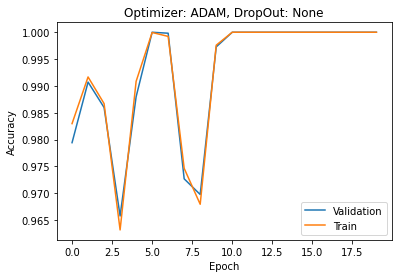

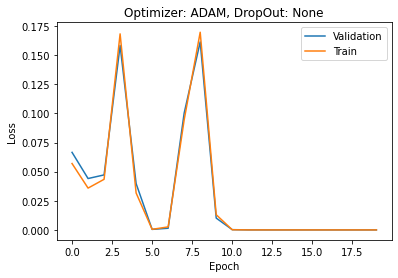

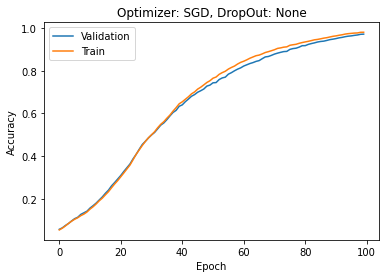

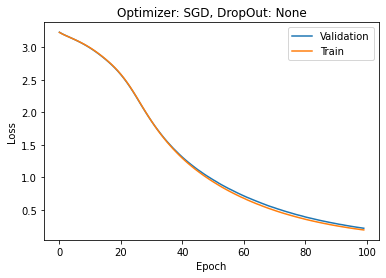

In [19]:
result_plotter(val_acc_adam_no_dropout, train_acc_adam_no_dropout, "Optimizer: ADAM, DropOut: None", ylabel="Accuracy")
result_plotter(val_loss_adam_no_dropout, train_loss_adam_no_dropout, "Optimizer: ADAM, DropOut: None", ylabel="Loss")

result_plotter(val_acc_sgd_no_dropout, train_acc_sgd_no_dropout, "Optimizer: SGD, DropOut: None", ylabel="Accuracy")
result_plotter(val_loss_sgd_no_dropout, train_loss_sgd_no_dropout, "Optimizer: SGD, DropOut: None", ylabel="Loss")

Difference between ADAM and SGD: ADAM adaptively finds the best learning rates from estimates of the first and second moments of the gradients, but SGD uses the input learning rate. Thus, ADAM yields less tuning and works with default inputs, however, one needs to tune learning rate of SGD.

The resutls in this question show that ADAM converges faster and yields better final accuracy and loss.

# c)

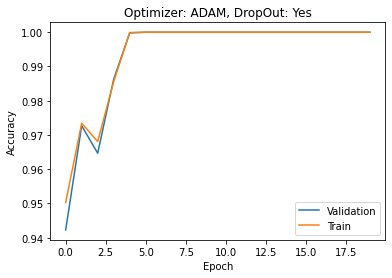

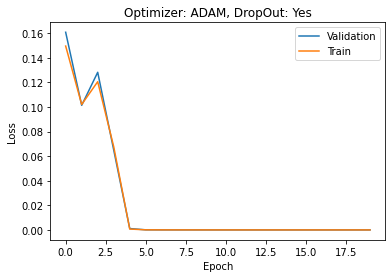

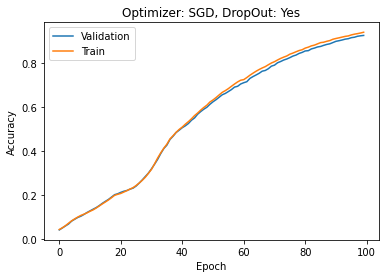

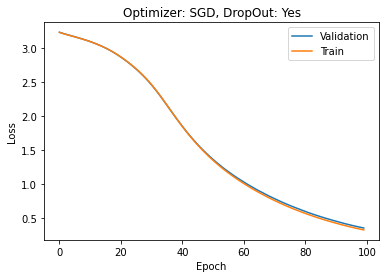

In [20]:
result_plotter(val_acc_adam_with_dropout, train_acc_adam_with_dropout, "Optimizer: ADAM, DropOut: Yes", ylabel="Accuracy")
result_plotter(val_loss_adam_with_dropout, train_loss_adam_with_dropout, "Optimizer: ADAM, DropOut: Yes", ylabel="Loss")

result_plotter(val_acc_sgd_with_dropout, train_acc_sgd_with_dropout, "Optimizer: SGD, DropOut: Yes", ylabel="Accuracy")
result_plotter(val_loss_sgd_with_dropout, train_loss_sgd_with_dropout, "Optimizer: SGD, DropOut: Yes", ylabel="Loss")

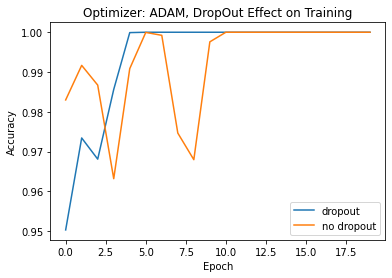

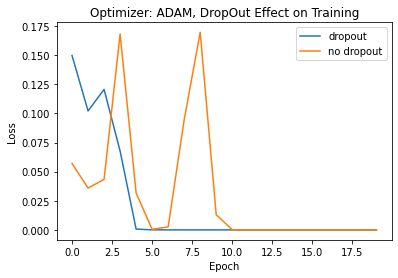

In [22]:
result_plotter(train_acc_adam_with_dropout, train_acc_adam_no_dropout, "Optimizer: ADAM, DropOut Effect on Training", ylabel="Accuracy", legends=["dropout", "no dropout"])
result_plotter(train_loss_adam_with_dropout, train_loss_adam_no_dropout, "Optimizer: ADAM, DropOut Effect on Training", ylabel="Loss", legends=["dropout", "no dropout"])

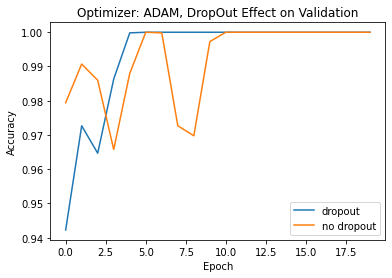

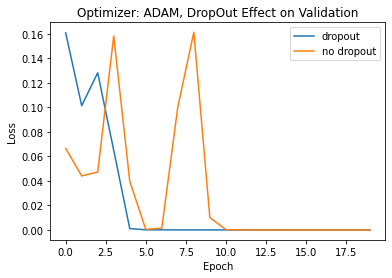

In [24]:
result_plotter(val_acc_adam_with_dropout, val_acc_adam_no_dropout, "Optimizer: ADAM, DropOut Effect on Validation", ylabel="Accuracy", legends=["dropout", "no dropout"])
result_plotter(val_loss_adam_with_dropout, val_loss_adam_no_dropout, "Optimizer: ADAM, DropOut Effect on Validation", ylabel="Loss", legends=["dropout", "no dropout"])

We can see that the dropout results in slower learning rate at first, but converges faster at the end. Surprisingly, this effect is the same on both training and validation data.

# d)

From the above results, it seem that it is best to use ADAM optimizer with dropout layers. Now we can see the results on test data.

In [26]:
test_acc, test_loss = net_adam_with_dropout.evaluate(test_dataset, len(test_dataset))
print(f"Final model accuracy on test data is {test_acc}")

Final model accuracy on test data is 0.8234801888465881


# e)

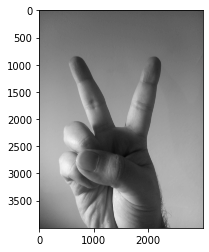

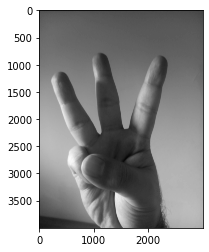

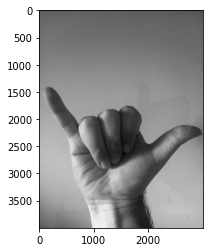

In [175]:
img1 = cv2.imread("./Data/HW2_data/img1.jpg")
img2 = cv2.imread("./Data/HW2_data/img2.jpg")
img3 = cv2.imread("./Data/HW2_data/img3.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img1, cmap='gray')
plt.figure()
plt.imshow(img2, cmap='gray')
plt.figure()
plt.imshow(img3, cmap='gray')
plt.show()

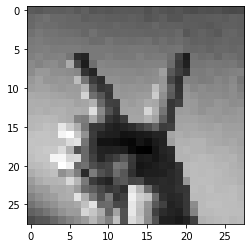

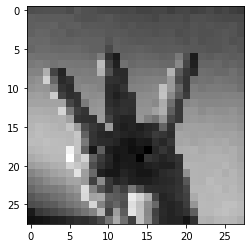

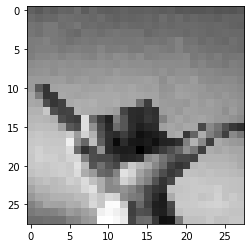

In [176]:
img1 = cv2.resize(img1, (28, 28))
img2 = cv2.resize(img2, (28, 28))
img3 = cv2.resize(img3, (28, 28))

plt.figure()
plt.imshow(img1, cmap='gray')
plt.figure()
plt.imshow(img2, cmap='gray')
plt.figure()
plt.imshow(img3, cmap='gray')
plt.show()

In [177]:
my_images = [img1.astype(float), img2.astype(float), img3.astype(float)]
mu_new, sigma_new = np.array(my_images).mean(), np.array(my_images).std()
my_images_normalized = [transform_norm(img) for img in my_images]

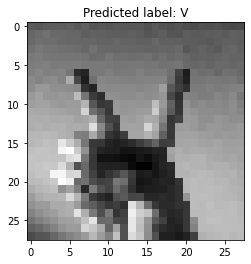

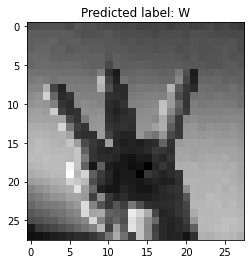

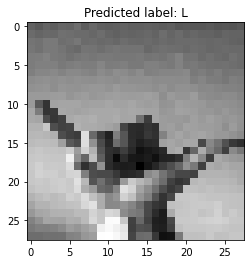

In [178]:
net_adam_with_dropout.eval()
for i, img in enumerate(my_images_normalized):
    with torch.no_grad():
        out = net_adam_with_dropout.model(img.view((1, 784)).float())
        plt.figure()
        plt.imshow(img.numpy()[0], cmap='gray')
        plt.title(f"Predicted label: " + chr(65 + torch.argmax(out, dim=-1)))